# environment

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import gc, argparse, sys, os, errno
from IPython.core.display import HTML,Image
from functools import reduce
import h5py
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c,Set3,Pastel2
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
from IPython.core.display import HTML,Image
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
from IPython.display import HTML, display, FileLink
from base64 import b64encode, b64decode
from io import StringIO, BytesIO
from contextlib import contextmanager

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
cd ~chenxupeng/projects/exSEEK_training/

/home/chenxupeng/projects/exSEEK_training


In [6]:
# setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
# force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot

In [14]:
fonttitle = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5}
fontlabel = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5}
fontticklabel = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5}
fontlegend = {'family':'Arial',
                  'weight' : 'normal', 
              #'linewidth':0.5,
                  'size' : 6.5}
fontcbarlabel = {'family':'Arial',
                 'weight' : 'normal', 
                 #'Rotation' : 270,
                 #'labelpad' : 25,
                 'size' : 6.5}
fontcbarticklabel = {'family':'Arial',#Helvetica
                 'weight' : 'normal', 
                 'size' : 5.5}

In [7]:
def legendhandle(lists,porm=True,order=0):
    '''
        input: array,porm palette or marker
        palettesorder=0 dataset Category20c
        palettesorder=1 batch

        return a dic mapping levels of the hue variable to colors
        or return a dic mapping levels of the style variable to markers
        when use sns function, set palette=dic or markers=dic

    '''
    if porm == True:
        if order == 0:
            palette = np.array(Category20c[20]).reshape(4,-1).T.ravel()
        if order == 1:
            palette = Set3[12]
        lists.sort()
        dic={}
        for i in range(len(lists)):
            dic[lists[i]]=palette[i]
        return dic
    else:
        markerlist1 = ['v','^','<','>'] #triangle_down triangle_up triangle_left triangle_left
        markerlist2 = ['P','o','X','s'] #plus (filled) circle x (filled) square
        #markerlist3 = ['$CPM$','$CPM_top$','$RLE$','$TMM$']
        markerlist3 = ['$f$','$g$','$h$','$l$']
        markerlist3.sort()
        if order == 0:
            markers = markerlist2
        if order == 1:
            markers = markerlist1
        if order == 2:
            markers = markerlist3
            
        lists.sort()
        dic={}
        for i in range(len(lists)):
            dic[lists[i]]=markers[i]
        return dic       


In [8]:
savepath = '/home/chenxupeng/projects/exSEEK_training/'+'output/'+'fig3'+'/'

if not os.path.exists(savepath):
    os.mkdir(savepath)

# RLE

In [9]:
def plotRLE(mat,batch=None,label=None,logged=False,path=None,filename=None,title=None):
    """
    mat: DataFrame, expression matrix
    batch: DataFrame, optional, if given, batch.index must be contained in mat.columns
    label: One of batch.columns by which the samples are grouped in the figure
    """
    log_mat = mat if logged else np.log2(mat+1)
    feature_meds = log_mat.apply(np.median,1).tolist()
    for i in np.arange(len(feature_meds)):
        log_mat.iloc[i] = log_mat.iloc[i] - feature_meds[i]
    mat_rle = log_mat
    stack = mat_rle.stack().reset_index()
    stack.rename(columns={stack.columns[2]:"counts", stack.columns[1]: "index"},inplace=True)
    #stack['class'] = None
    if batch is not None:
        batch.index.name = 'index'
        batch = batch[label].reset_index()
        stack = pd.merge(stack, batch, on=['index'])
        fig,ax = plt.subplots(figsize=(2,2))
        #ax = sns.boxplot(x='index',y='counts',data=stack.sort_values(by=label),fliersize=0,linewidth=0.1,width=1,hue=label,hue_order=np.unique(np.array(stack.loc[:,label])).sort(),dodge=False)
        ax = sns.boxplot(x='index',y='counts',data=stack.sort_values(by=label),
                     fliersize=0,linewidth=0,width=0.8,hue=label,
                     hue_order=np.unique(np.array(stack.loc[:,label])).sort(),
                     notch = True,showfliers=False,showmeans=False,showcaps=False,whiskerprops=dict(linewidth=0.5,color='#D8D8D8'),
                     dodge=False,palette=legendhandle(np.unique(stack.dataset)))        
        ax.set(xticks=[])
        std_plot(ax,'sample','RLE',legendtitle='label',legendsort=False,title=title,ybins=4,)#ylim=[-4,4])
    else:
        fig,ax = plt.subplots(figsize=(3,2))
        ax = sns.boxplot(x='index',y='counts',data=stack,fliersize=0,linewidth=0.1,width=1,color='g')
        ax.set(xticks=[])
        std_plot(ax,'sample','RLE',legendtitle='label',legendsort=False,ylim=[-10,10],title=title,ybins=4)
    #ax.legend_.remove()
    legend = ax.legend(prop=fontlegend,
                  #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,bbox_to_anchor=(1.05, 0.75))
    ax.legend_.get_frame()._linewidth=0
    ax.legend_.remove()
    ax.spines['bottom'].set_visible(False)
    fig.tight_layout()
    embed_pdf_figure()
    fig.savefig(path+filename)

In [10]:
normlist= ['filter.null.Norm_CPM','filter.null.Norm_CPM_top',#'filter.null.Norm_null',
           #'filter.null.Norm_CPM_top_5','filter.null.Norm_CPM_top_10',
           #'filter.null.Norm_CPM_top_20','filter.null.Norm_CPM_top_40',
           'filter.null.Norm_RLE','filter.null.Norm_TMM']
batchlist = ['Batch_ComBat_1','Batch_null','Batch_RUV','Batch_limma_1']

In [11]:
methodlist = []
for i in normlist:
    #for j in batchlist:
    j=batchlist[1]
    methodlist.append(i+'.'+j)
methodlist

['filter.null.Norm_CPM.Batch_null',
 'filter.null.Norm_CPM_top.Batch_null',
 'filter.null.Norm_RLE.Batch_null',
 'filter.null.Norm_TMM.Batch_null']

In [15]:
class_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt',index_col=0)
class_info[class_info.dataset=='lulab_hcc']='GSE123972'


In [16]:
for i in tqdm((methodlist)):
    table = pd.read_table('~/fig3/output/'+'cfRNA'+'/matrix_processing/'+i+'.mirna_and_domains.txt',
                           index_col=0)
    plotRLE(table,batch=class_info,label='dataset',path=savepath,filename='RLE_leg_big{}.eps'.format(i),title=i.split('.')[2])
    

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [17]:
table = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/count_matrix/mirna_and_domains.txt',
                           index_col=0)
plotRLE(table,batch=class_info,label='dataset',path=savepath,filename='RLE_noleg_{}.eps'.format('null'),title='Raw')

In [18]:
def plotRLE(ax,mat,batch=None,label=None,logged=False,path=None,filename=None,title=None,ylim=None,ylabel='',color='#E5E5E5'):
    """
    mat: DataFrame, expression matrix
    batch: DataFrame, optional, if given, batch.index must be contained in mat.columns
    label: One of batch.columns by which the samples are grouped in the figure
    """
    log_mat = mat if logged else np.log2(mat+1)
    feature_meds = log_mat.apply(np.median,1).tolist()
    for i in np.arange(len(feature_meds)):
        log_mat.iloc[i] = log_mat.iloc[i] - feature_meds[i]
    mat_rle = log_mat
    stack = mat_rle.stack().reset_index()
    stack.rename(columns={stack.columns[2]:"counts", stack.columns[1]: "index"},inplace=True)
    #stack['class'] = None
    if batch is not None:
        batch.index.name = 'index'
        batch = batch[label].reset_index()
        stack = pd.merge(stack, batch, on=['index'])
        
        #ax = sns.boxplot(x='index',y='counts',data=stack.sort_values(by=label),fliersize=0,linewidth=0.1,width=1,hue=label,hue_order=np.unique(np.array(stack.loc[:,label])).sort(),dodge=False)
        ax = sns.boxplot(ax=ax,x='index',y='counts',data=stack.sort_values(by=label),
                     fliersize=0,linewidth=0,width=0.8,hue=label,
                     hue_order=np.unique(np.array(stack.loc[:,label])).sort(),
                     notch = True,showfliers=False,showmeans=False,showcaps=False,whiskerprops=dict(linewidth=0.4,color=color),
                     dodge=False,palette=legendhandle(np.unique(stack.dataset)))        
        ax.set(xticks=[])
        std_plot(ax,'sample',ylabel,legendtitle='label',legendsort=False,title=title,ybins=4,ylim=ylim)
    else:
        #fig,ax = plt.subplots(figsize=(3,2))
        ax = sns.boxplot(ax=ax,x='index',y='counts',data=stack,fliersize=0,linewidth=0.1,width=1,color='g')
        ax.set(xticks=[])
        std_plot(ax,'sample','RLE',legendtitle='label',legendsort=False,ylim=[-10,10],title=title,ybins=4)
    #ax.legend_.remove()
    legend = ax.legend(prop=fontlegend,
                  #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,bbox_to_anchor=(1.05, 0.75))
    ax.legend_.get_frame()._linewidth=0
    ax.legend_.remove()
    ax.spines['bottom'].set_visible(False)

In [19]:
methodlist

['filter.null.Norm_CPM.Batch_null',
 'filter.null.Norm_CPM_top.Batch_null',
 'filter.null.Norm_RLE.Batch_null',
 'filter.null.Norm_TMM.Batch_null']

In [20]:
fig,axes = plt.subplots(1,len(methodlist)+1,figsize=(8,2))
table = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/count_matrix/mirna_and_domains.txt',
                           index_col=0)
plotRLE(axes[0],table,batch=class_info,label='dataset',path=savepath,filename='RLE_noleg_{}.eps'.format('null'),title='Raw',ylabel='RLE')
j=1    
for i in tqdm((methodlist)):
    table = pd.read_table('~/fig3/output/'+'cfRNA'+'/matrix_processing/'+i+'.mirna_and_domains.txt',
                           index_col=0)
    if j==1:
        plotRLE(axes[j],table,batch=class_info,label='dataset',path=savepath,filename='RLE_leg_big{}.eps'.format(i),title=i.split('.')[2],ylim=[-4,4],ylabel='')
    else:
        if i=='filter.null.Norm_RLE.Batch_null':
            plotRLE(axes[j],table,batch=class_info,label='dataset',path=savepath,filename='RLE_leg_big{}.eps'.format(i),title=i.split('.')[2],ylim=[-4,4],ylabel='',color='#B7B7B7')
        else: 
            plotRLE(axes[j],table,batch=class_info,label='dataset',path=savepath,filename='RLE_leg_big{}.eps'.format(i),title=i.split('.')[2],ylim=[-4,4],ylabel='')
        axes[j].set(yticks=[])
        axes[j].spines['left'].set_visible(False)
    j=j+1
j=j-1
legend = axes[j].legend(prop=fontlegend,
              #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
              edgecolor="#000000",fancybox=False,bbox_to_anchor=(1.05, 0.75))
axes[j].legend_.get_frame()._linewidth=0
fig.tight_layout()
fig.savefig(savepath+'demo.eps')
embed_pdf_figure()

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

# heterogeneity

In [21]:
def hetero(mat1,mat2,class_info,featurenum=2):
    data1 = np.log2(mat1.iloc[np.where(np.isin([i.split('|')[0] for i in mat1.index],ref))]+1)
    data1 = data1.loc[:,class_info.sort_values(by=['label']).sample_id]
    featurelist = pd.DataFrame(data1.sum(axis=1))
    featurelist.columns=['counts']
    ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
    data_del1 = data1.loc[ref_del]
    stack1 = pd.DataFrame(data_del1.stack())
    stack1 = stack1.reset_index()
    stack1.columns=['feature','sample_id','log2(count+1)']
    merge1 = pd.merge(stack1,class_info,on=['sample_id'])
    
    data2 = np.log2(mat2.iloc[np.where(np.isin([i.split('|')[0] for i in mat2.index],ref))]+1)
    data2 = data2.loc[:,class_info.sort_values(by=['label']).sample_id]
    #featurelist = pd.DataFrame(data1.sum(axis=1))
    #featurelist.columns=['counts']
    #ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
    data_del2 = data2.loc[ref_del]
    stack2 = pd.DataFrame(data_del2.stack())
    stack2 = stack2.reset_index()
    stack2.columns=['feature','sample_id','log2(count+1)']
    merge2 = pd.merge(stack2,class_info,on=['sample_id'])
    import seaborn as sns
    import matplotlib.pyplot as plt
    linestyles = ['-','--',':']
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3))
    j = -1
    for i in np.unique(merge1['feature']):
        j = j+1
        sns.pointplot(ax=ax1,x="sample_id", y="log2(count+1)",hue='label',palette='Set1',linestyles=linestyles[j],
                      scale=0.5,
                      data=merge1.iloc[np.where(np.isin(merge1['feature'],i))])
        if j==0:
            h,l = ax1.get_legend_handles_labels()
    legend = ax1.legend(h,l,title='label',prop=fontlegend,
                      bbox_to_anchor=None,
                      labelspacing=1.2,borderpad=1,handletextpad=0,
                      edgecolor="#000000",fancybox=False,markerscale=None)
    ax1.legend_.get_frame()._linewidth=0.5
    legend.get_title().set_fontweight('normal')
    legend.get_title().set_fontsize(6.5)
    ax1.set_xticks([])
    std_plot(ax1,'','log2(count+1)','raw matrix heterogeneity plot',ylim=[0,25])
    
    j = -1
    for i in np.unique(merge2['feature']):
        j = j+1
        sns.pointplot(ax=ax2,x="sample_id", y="log2(count+1)",hue='label',palette='Set1',linestyles=linestyles[j],
                      scale=0.5,
                      data=merge2.iloc[np.where(np.isin(merge2['feature'],i))])
        if j==0:
            h,l = ax2.get_legend_handles_labels()
    legend = ax2.legend(h,l,title='label',prop=fontlegend,
                      bbox_to_anchor=None,
                      labelspacing=1.2,borderpad=1,handletextpad=0,
                      edgecolor="#000000",fancybox=False,markerscale=None)
    ax2.legend_.get_frame()._linewidth=0.5
    legend.get_title().set_fontweight('normal')
    legend.get_title().set_fontsize(6.5)
    ax2.set_xticks([])
    std_plot(ax2,'','log2(count+1)','normalized matrix heterogeneity plot',ylim=[0,25])
    embed_pdf_figure()
    fig.savefig(savepath+'heterogeneity.eps', bbox_inches='tight')

In [22]:
ref = pd.read_table('/home/xieyufeng/exSeek/data/matrix_processing/ref_mirbase_gid.txt',header=-1)

In [23]:
#mat_raw = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/count_matrix/mirna_and_domains.txt',index_col=0)
mat_raw = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/count_matrix/mirna_and_domains.txt',index_col=0)
class_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/sample_classes.txt')
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt')

In [24]:
class_info = \
class_info.set_index('sample_id').drop(index=batch_info.iloc[np.where(batch_info.dataset=='GSE113994')].sample(frac=0.5).sample_id)
class_info = class_info.reset_index()


In [25]:
hcc_class_info =pd.read_table('/home/shibinbin/projects/exSeek-dev/data/lulab_hcc/sample_classes.txt')


In [26]:
class_info_del = class_info.drop((np.where((class_info.label != 'Normal')|\
                                           (np.isin(class_info.sample_id,hcc_class_info.sample_id)))[0]))

In [27]:
samplename = class_info_del.sample_id.tolist()
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt')
batch_info = batch_info.set_index('sample_id').loc[samplename].reset_index()
batch_info.columns=['sample_id','label']
mat_norm = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_RLE.mirna_and_domains.txt',index_col=0)


In [28]:
hetero(mat_raw.loc[:,samplename],\
       mat_norm.loc[:,samplename],\
       batch_info,featurenum=2)

# another hetero

In [29]:
ref = pd.read_table('/home/xieyufeng/exSeek/data/matrix_processing/ref_mirbase_gid.txt',header=-1)
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt')
batch_info.columns=['sample_id','label']
mat_raw = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/count_matrix/mirna_and_domains.txt',index_col=0)
mat_norm = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_RLE.mirna_and_domains.txt',index_col=0)


In [30]:
def heterogeneity(mat1=mat_raw,mat2=mat_norm,class_info=batch_info,featurenum=4,featurename=None):
    def get_box_data(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        cat = boxName
        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]
        return group_data
    def find_x_position_box(boxPlotter, boxName):
        cat = boxName
        groupPos = boxPlotter.group_names.index(cat)
        return groupPos
    class_info = class_info.drop(np.where(class_info.label=='lulab_hcc')[0]).set_index('sample_id').reset_index()
    samplemin = np.unique(class_info.label,return_counts=True)[1].min()
    new_class_info = pd.DataFrame([])
    for i in unique(class_info.label):
        extra_class_info = class_info.iloc[np.where(class_info.label==i)]
        new_class_info = new_class_info.append(extra_class_info.sample(n=samplemin))
    new_class_info = new_class_info.sort_values(by=['label','sample_id']).set_index('sample_id').reset_index()

    mat1 = mat1.loc[:,new_class_info.sample_id]
    mat2 = mat2.loc[:,new_class_info.sample_id]
    data1 = np.log2(mat1.iloc[np.where(np.isin([i.split('|')[0] for i in mat1.index],ref))]+1)
    featurelist = pd.DataFrame(data1.sum(axis=1))
    featurelist.columns=['counts']
    ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
    data_del1 = data1.loc[ref_del]
    stack1 = pd.DataFrame(data_del1.stack())
    stack1 = stack1.reset_index()
    stack1.columns=['feature','sample_id','log2(count+1)']
    merge1 = pd.merge(stack1,new_class_info,on=['sample_id'])
    merge1['state'] = 'raw'
    data2 = np.log2(mat2.iloc[np.where(np.isin([i.split('|')[0] for i in mat2.index],ref))]+1)

    data_del2 = data2.loc[ref_del]
    stack2 = pd.DataFrame(data_del2.stack())
    stack2 = stack2.reset_index()
    stack2.columns=['feature','sample_id','log2(count+1)']
    merge2 = pd.merge(stack2,class_info,on=['sample_id'])
    merge2['state'] = 'normalized'
    plot = merge1.append(merge2)
    plot['name_state']=[plot.feature.iloc[i].split('|')[0]+'|'+plot.state.iloc[i] for i in range(len(plot.feature))]
    #plot = plot.sort_values(by=['name_state'])
    plot = plot.set_index('feature').reset_index()
    for feature in np.unique(plot.feature):
        if (feature.split('|')[0]==featurename)|(featurename==None):
            data_sub = plot.iloc[np.where(plot.feature == feature)]
            data_sub = data_sub.set_index('feature').reset_index()
            colormap = pd.DataFrame(np.array([np.unique(data_sub.label),np.array(Category20c[20]).reshape(4,-1).T.ravel()[:len(np.unique(data_sub.label))].tolist()]))
            colormap = colormap.T
            colormap.columns=['label','color']
            data_sub = data_sub.merge(colormap)

            fig,ax = plt.subplots(figsize=(7,3))
            y1_=0
            y2_=0
            for label in np.unique(data_sub.label):
                data_sub_sub = data_sub.iloc[np.where(data_sub.label == label)]
                data_sub_sub['state_sample_id'] = [data_sub_sub.state.iloc[i]+'|'+\
                                                   str(i) for i in range(len(data_sub_sub))]
                sns.pointplot(ax=ax,x="state_sample_id", y="log2(count+1)",palette=data_sub_sub.color,hue=data_sub_sub.label,
                                  data=data_sub_sub,scale=0.7)
                #ax.scatter(data_sub_sub.state_sample_id.tolist(),data_sub_sub['log2(count+1)'].tolist(),color=data_sub_sub.color.tolist())
                boxPlotter = sns.categorical._BoxPlotter(data=data_sub_sub,x='state_sample_id',y='log2(count+1)',hue=data_sub_sub.label,
                                                         order=None, hue_order=None,
                                                             orient=None, width=.8, color=None, palette=None, saturation=.75,
                                                             dodge=True, fliersize=5, linewidth=None)

                box1 = [boxPlotter.group_names[i] for i in range(ax.get_xticks()[0],
                                                          math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2))]
                box_data1 = []
                for i in box1:
                    box_data1.append(get_box_data(boxPlotter, i)[0]) 
                box2 = [boxPlotter.group_names[i] for i in range(math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2),
                                                                 ax.get_xticks()[-1])]
                box_data2 = []
                for i in box2:
                    box_data2.append(get_box_data(boxPlotter, i)[0]) 
                ylim = ax.get_ylim()
                yRange = ylim[1] - ylim[0]
                lineYOffsetAxesCoord = 0.05
                lineYOffsetToBoxAxesCoord = 0.06
                lineHeightAxesCoord=0.02
                yOffset = lineYOffsetAxesCoord*yRange
                yOffsetToBox = lineYOffsetToBoxAxesCoord*yRange

                ymax1 = np.array(box_data1).max()
                ymax2 = np.array(box_data2).max()
                y1 = ymax1 + yOffsetToBox
                y2 = ymax2 + yOffsetToBox
                if y1>y1_:
                    y1_=y1
                if y2>y2_:
                    y2_=y2
            h = lineHeightAxesCoord*yRange
            lineX1, lineY1 = [ax.get_xticks()[0], math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)], [y1_ + h, y1_ + h]
            ax.plot(lineX1, lineY1,color='Black',linewidth='0.5')
            lineX2, lineY2 = [math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2),ax.get_xticks()[-1]], [y2_ + h, y2_ + h]
            ax.plot(lineX2, lineY2,color='Black',linewidth='0.5')
            ax.annotate('raw', xy=(np.mean([ax.get_xticks()[0], math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)]), y1_ + h),
                      xytext=(0, 1), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom', fontfamily='Arial',fontsize=6.5,
                      clip_on=False, annotation_clip=False)
            ax.annotate('normalized', xy=(np.mean([ax.get_xticks()[-1], math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)]), y2_ + h),
                      xytext=(0, 1), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom', fontfamily='Arial',fontsize=6.5,
                      clip_on=False, annotation_clip=False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            #ax.legend(h,l,prop=fontlegend)
            std_plot(ax,'','',legendtitle='label',legendsort=False,title=feature.split('|')[0])
            embed_pdf_figure()
            fig.savefig(savepath+'{}_heterogeneity.eps'.format(feature.split('|')[0]), bbox_inches='tight')


In [31]:
heterogeneity(featurenum=10,featurename='hsa-miR-21-5p')

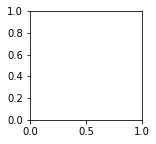

In [32]:
fig,ax=plt.subplots(figsize=(2,2))
fig.savefig(savepath+'demo.eps', bbox_inches='tight')

In [ ]:
# 

In [33]:
def heterogeneity(mat1=mat_raw,mat2=mat_norm,class_info=batch_info,featurenum=4,featurename=None,savename=None):
    def get_box_data(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        cat = boxName
        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]
        return group_data
    def find_x_position_box(boxPlotter, boxName):
        cat = boxName
        groupPos = boxPlotter.group_names.index(cat)
        return groupPos
    class_info = class_info.drop(np.where(class_info.label=='lulab_hcc')[0]).set_index('sample_id').reset_index()
    samplemin = np.unique(class_info.label,return_counts=True)[1].min()
    new_class_info = pd.DataFrame([])
    for i in unique(class_info.label):
        extra_class_info = class_info.iloc[np.where(class_info.label==i)]
        new_class_info = new_class_info.append(extra_class_info.sample(n=samplemin))
    new_class_info = new_class_info.sort_values(by=['label','sample_id']).set_index('sample_id').reset_index()

    mat1 = mat1.loc[:,new_class_info.sample_id]
    mat2 = mat2.loc[:,new_class_info.sample_id]
    data1 = np.log2(mat1.iloc[np.where(np.isin([i.split('|')[0] for i in mat1.index],ref))]+1)
    featurelist = pd.DataFrame(data1.sum(axis=1))
    featurelist.columns=['counts']
    ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
    data_del1 = data1.loc[ref_del]
    stack1 = pd.DataFrame(data_del1.stack())
    stack1 = stack1.reset_index()
    stack1.columns=['feature','sample_id','log2(count+1)']
    merge1 = pd.merge(stack1,new_class_info,on=['sample_id'])
    merge1['state'] = 'raw'
    data2 = np.log2(mat2.iloc[np.where(np.isin([i.split('|')[0] for i in mat2.index],ref))]+1)

    data_del2 = data2.loc[ref_del]
    stack2 = pd.DataFrame(data_del2.stack())
    stack2 = stack2.reset_index()
    stack2.columns=['feature','sample_id','log2(count+1)']
    merge2 = pd.merge(stack2,class_info,on=['sample_id'])
    merge2['state'] = 'normalized'
    plot = merge1.append(merge2)
    plot['name_state']=[plot.feature.iloc[i].split('|')[0]+'|'+plot.state.iloc[i] for i in range(len(plot.feature))]
    #plot = plot.sort_values(by=['name_state'])
    plot = plot.set_index('feature').reset_index()
    for feature in np.unique(plot.feature):
        if (feature.split('|')[0]==featurename)|(featurename==None):
            data_sub = plot.iloc[np.where(plot.feature == feature)]
            data_sub = data_sub.set_index('feature').reset_index()
            colormap = pd.DataFrame(np.array([np.unique(data_sub.label),np.array(Category20c[20]).reshape(4,-1).T.ravel()[:len(np.unique(data_sub.label))].tolist()]))
            colormap = colormap.T
            colormap.columns=['label','color']
            data_sub = data_sub.merge(colormap)

            fig,ax = plt.subplots(figsize=(7,3))
            y1_=0
            y2_=0
            for label in np.unique(data_sub.label):
                data_sub_sub = data_sub.iloc[np.where(data_sub.label == label)]
                data_sub_sub['state_sample_id'] = [data_sub_sub.state.iloc[i]+'|'+\
                                                   str(i) for i in range(len(data_sub_sub))]
                sns.pointplot(ax=ax,x="state_sample_id", y="log2(count+1)",palette=data_sub_sub.color,hue=data_sub_sub.label,
                                  data=data_sub_sub,scale=0.7)
                #ax.scatter(data_sub_sub.state_sample_id.tolist(),data_sub_sub['log2(count+1)'].tolist(),color=data_sub_sub.color.tolist())
                boxPlotter = sns.categorical._BoxPlotter(data=data_sub_sub,x='state_sample_id',y='log2(count+1)',hue=data_sub_sub.label,
                                                         order=None, hue_order=None,
                                                             orient=None, width=.8, color=None, palette=None, saturation=.75,
                                                             dodge=True, fliersize=5, linewidth=None)

                box1 = [boxPlotter.group_names[i] for i in range(ax.get_xticks()[0],
                                                          math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2))]
                box_data1 = []
                for i in box1:
                    box_data1.append(get_box_data(boxPlotter, i)[0]) 
                box2 = [boxPlotter.group_names[i] for i in range(math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2),
                                                                 ax.get_xticks()[-1])]
                box_data2 = []
                for i in box2:
                    box_data2.append(get_box_data(boxPlotter, i)[0]) 
                ylim = ax.get_ylim()
                yRange = ylim[1] - ylim[0]
                lineYOffsetAxesCoord = 0.05
                lineYOffsetToBoxAxesCoord = 0.06
                lineHeightAxesCoord=0.02
                yOffset = lineYOffsetAxesCoord*yRange
                yOffsetToBox = lineYOffsetToBoxAxesCoord*yRange

                ymax1 = np.array(box_data1).max()
                ymax2 = np.array(box_data2).max()
                y1 = ymax1 + yOffsetToBox
                y2 = ymax2 + yOffsetToBox
                if y1>y1_:
                    y1_=y1
                if y2>y2_:
                    y2_=y2
            h = lineHeightAxesCoord*yRange
            lineX1, lineY1 = [ax.get_xticks()[0], math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)], [y1_ + h, y1_ + h]
            ax.plot(lineX1, lineY1,color='Black',linewidth='0.5')
            lineX2, lineY2 = [math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2),ax.get_xticks()[-1]], [y2_ + h, y2_ + h]
            ax.plot(lineX2, lineY2,color='Black',linewidth='0.5')
            ax.annotate('raw', xy=(np.mean([ax.get_xticks()[0], math.floor((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)]), y1_ + h),
                      xytext=(0, 1), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom', fontfamily='Arial',fontsize=6.5,
                      clip_on=False, annotation_clip=False)
            ax.annotate('normalized', xy=(np.mean([ax.get_xticks()[-1], math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/2)]), y2_ + h),
                      xytext=(0, 1), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom', fontfamily='Arial',fontsize=6.5,
                      clip_on=False, annotation_clip=False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            #ax.legend(h,l,prop=fontlegend)
            std_plot(ax,'','',legendtitle='label',legendsort=False,title=feature.split('|')[0])
            embed_pdf_figure()
            fig.savefig(savepath+'{}_heterogeneity.eps'.format(savename), bbox_inches='tight')


In [34]:
for i in tqdm(methodlist):
    table = pd.read_table('~/fig3/output/'+'cfRNA'+'/matrix_processing/'+i+'.mirna_and_domains.txt',
                           index_col=0)
    heterogeneity(mat1=mat_raw,mat2=table,class_info=batch_info,featurenum=4,featurename='hsa-miR-21-5p',savename=i)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

# hetero 

In [35]:
methodlist = ['filter.null.mirna_and_domains.txt',
              'filter.null.Norm_RLE.mirna_and_domains.txt',
              'filter.null.Norm_CPM.mirna_and_domains.txt',
              'filter.null.Norm_CPM_top.mirna_and_domains.txt',
              'filter.null.Norm_TMM.mirna_and_domains.txt']

In [36]:
ref = pd.read_table('/home/xieyufeng/exSeek/data/matrix_processing/ref_mirbase_gid.txt',header=-1)
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt')
batch_info.columns=['sample_id','label']
batch_info['label'].iloc[np.where(batch_info.label=='lulab_hcc')]='GSE123972'

In [37]:
def heterogeneity(matlist=methodlist,class_info=batch_info,featurenum=4,featurename=None):
    def get_box_data(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        cat = boxName
        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]
        return group_data
    def find_x_position_box(boxPlotter, boxName):
        cat = boxName
        groupPos = boxPlotter.group_names.index(cat)
        return groupPos
    classname = np.unique(class_info.label)
    classname.sort()
    colormap = pd.DataFrame(np.array([classname,np.array(Category20c[20]).reshape(4,-1).T.ravel()[:len(np.unique(class_info.label))].tolist()]))
    colormap = colormap.T
    colormap.columns=['label','color']
    class_info = class_info.drop(np.where(class_info.label=='GSE123972')[0]).drop(np.where(class_info.label=='GSE94582')[0]).set_index('sample_id').reset_index()
    samplemin = np.unique(class_info.label,return_counts=True)[1].min()
    new_class_info = pd.DataFrame([])
    for i in unique(class_info.label):
        extra_class_info = class_info.iloc[np.where(class_info.label==i)]
        new_class_info = new_class_info.append(extra_class_info.sample(n=samplemin))
    new_class_info = new_class_info.sort_values(by=['label','sample_id']).set_index('sample_id').reset_index()
    flag = 0
    plot = pd.DataFrame()
    for matname in matlist:
        mat = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/matrix_processing/'\
                            +matname,index_col=0)
        mat = mat.loc[:,new_class_info.sample_id]
        data = np.log2(mat.iloc[np.where(np.isin([i.split('|')[0] for i in mat.index],ref))]+1)
        if flag == 0:
            featurelist = pd.DataFrame(data.sum(axis=1))
            featurelist.columns=['counts']
            ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
        data_del = data.loc[ref_del]
        stack = pd.DataFrame(data_del.stack())
        stack = stack.reset_index()
        stack.columns=['feature','sample_id','log2(count+1)']
        merge = pd.merge(stack,new_class_info,on=['sample_id'])
        merge['state'] = matname
        plot = plot.append(merge)
    plot['name_state']=[plot.feature.iloc[i].split('|')[0]+'|'+plot.state.iloc[i] for i in range(len(plot.feature))]
    #plot = plot.sort_values(by=['name_state'])
    plot = plot.set_index('feature').reset_index()
    for feature in np.unique(plot.feature):
        if (feature.split('|')[0]==featurename)|(featurename==None):
            data_sub = plot.iloc[np.where(plot.feature == feature)]
            data_sub = data_sub.set_index('feature').reset_index()
            #colormap = pd.DataFrame(np.array([np.unique(data_sub.label),np.array(Category20c[20]).reshape(4,-1).T.ravel()[:len(np.unique(data_sub.label))].tolist()]))
            #colormap = colormap.T
            #colormap.columns=['label','color']
            #data_sub = data_sub.merge(colormap)
            data_sub = pd.merge(data_sub, colormap, how='left', on=['label'])
            fig,ax = plt.subplots(figsize=(3.5,2))
            ylist=[0]*len(matlist)
            for label in np.unique(data_sub.label):
                data_sub_sub = data_sub.iloc[np.where(data_sub.label == label)]
                data_sub_sub['state_sample_id'] = [data_sub_sub.state.iloc[i]+'|'+\
                                                   str(i) for i in range(len(data_sub_sub))]
                sns.pointplot(ax=ax,x="state_sample_id", y="log2(count+1)",palette=data_sub_sub.color,hue=data_sub_sub.label,
                                  data=data_sub_sub,scale=0.2)
                #ax.scatter(data_sub_sub.state_sample_id.tolist(),data_sub_sub['log2(count+1)'].tolist(),color=data_sub_sub.color.tolist())
                boxPlotter = sns.categorical._BoxPlotter(data=data_sub_sub,x='state_sample_id',y='log2(count+1)',hue=data_sub_sub.label,
                                                         order=None, hue_order=None,
                                                             orient=None, width=.8, color=None, palette=None, saturation=.75,
                                                             dodge=True, fliersize=5, linewidth=None)
                linenum = len(matlist)
                start = ax.get_xticks()[0]
                binwidth = math.ceil((ax.get_xticks()[0]+ax.get_xticks()[-1])/linenum)
                for loc in range(linenum):
                    box = [boxPlotter.group_names[i] for i in range(start+loc*binwidth,start+(loc+1)*binwidth)]
                    box_data = []
                    for i in box:
                        box_data.append(get_box_data(boxPlotter, i)[0]) 
                    ylim = ax.get_ylim()
                    yRange = ylim[1] - ylim[0]
                    lineYOffsetAxesCoord = 0.05
                    lineYOffsetToBoxAxesCoord = 0.06
                    lineHeightAxesCoord=0.02
                    yOffset = lineYOffsetAxesCoord*yRange
                    yOffsetToBox = lineYOffsetToBoxAxesCoord*yRange

                    ymax = np.array(box_data).max()
                    y = ymax + yOffsetToBox
                    if y>=ylist[loc]:
                        ylist[loc]=y
            h = lineHeightAxesCoord*yRange
            #title = [i.split('.')[2] for i in matlist]
            #title = ['Raw' if x == 'mirna_and_domains' else x for x in title]  
            title = ['Raw','RLE','CPM','CPM_top','TMM']
            for loc in range(linenum):
                lineX, lineY = [start+loc*binwidth,start+(loc+1)*binwidth], [ylist[loc]+h,ylist[loc]+h]
                ax.plot(lineX, lineY,color='Black',linewidth='0.5')
                ax.annotate(title[loc], xy=(np.mean([start+loc*binwidth,start+(loc+1)*binwidth]), ylist[loc]+h),
                          xytext=(0, 1), textcoords='offset points',
                          xycoords='data', ha='center', va='bottom', fontfamily='Arial',fontsize=5.5,
                          clip_on=False, annotation_clip=False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            #ax.legend(h,l,prop=fontlegend)
            #std_plot(ax,'','',legendtitle='label',legendsort=False,title=feature.split('|')[0])
            #ax.legend_.remove()
            std_plot(ax,'','Normalized counts',legendtitle='label',legendsort=False,title=feature.split('|')[0])
            legend = ax.legend(prop=fontlegend,
                  #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,bbox_to_anchor=(1, 1.1))
            ax.legend_.get_frame()._linewidth=0
            #ax.legend_.remove()
            fig.tight_layout()
            embed_pdf_figure()
            fig.savefig(savepath+'{}_heterogeneity_noleg_2.eps'.format(feature.split('|')[0]))
heterogeneity()

In [38]:
def heterogeneity(matlist=methodlist,class_info=batch_info,featurenum=4,featurename=None):
    def get_box_data(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        cat = boxName
        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]
        return group_data
    def find_x_position_box(boxPlotter, boxName):
        cat = boxName
        groupPos = boxPlotter.group_names.index(cat)
        return groupPos
    classname = np.unique(class_info.label)
    classname.sort()
    colormap = pd.DataFrame(np.array([classname,np.array(Category20c[20]).reshape(4,-1).T.ravel()[:len(np.unique(class_info.label))].tolist()]))
    colormap = colormap.T
    colormap.columns=['label','color']
    class_info = class_info.drop(np.where(class_info.label=='GSE123972')[0]).drop(np.where(class_info.label=='GSE94582')[0]).set_index('sample_id').reset_index()
    samplemin = np.unique(class_info.label,return_counts=True)[1].min()
    new_class_info = pd.DataFrame([])
    for i in unique(class_info.label):
        extra_class_info = class_info.iloc[np.where(class_info.label==i)]
        new_class_info = new_class_info.append(extra_class_info.sample(n=samplemin))
    new_class_info = new_class_info.sort_values(by=['label','sample_id']).set_index('sample_id').reset_index()
    flag = 0
    plot = pd.DataFrame()
    for matindex in range(len(matlist)):
        mat = pd.read_table('/home/shibinbin/projects/exSeek-dev/output/cfRNA/matrix_processing/'\
                            +matlist[matindex],index_col=0)
        mat = mat.loc[:,new_class_info.sample_id]
        data = np.log2(mat.iloc[np.where(np.isin([i.split('|')[0] for i in mat.index],ref))]+1)
        if flag == 0:
            featurelist = pd.DataFrame(data.sum(axis=1))
            featurelist.columns=['counts']
            ref_del = featurelist.sort_values(by='counts',ascending=False).index[:featurenum].tolist()
        data_del = data.loc[ref_del]
        stack = pd.DataFrame(data_del.stack())
        stack = stack.reset_index()
        stack.columns=['feature','sample_id','log2(count+1)']
        merge = pd.merge(stack,new_class_info,on=['sample_id'])
        merge['state'] = matlist[matindex]
        plot = plot.append(merge)
        plot = plot.set_index('feature').reset_index()
    title = [i.split('.')[2] for i in matlist]
    title = ['Raw' if x == 'mirna_and_domains' else x for x in title]   
    for feature in np.unique(plot.feature):
        if (feature.split('|')[0]==featurename)|(featurename==None):
            data_sub = plot.iloc[np.where(plot.feature == feature)]
            data_sub = data_sub.set_index('feature').reset_index()

            #data_sub = data_sub.merge(colormap)
            data_sub = pd.merge(data_sub, colormap, how='left', on=['label'])
            fig,ax = plt.subplots(len(matlist),1,figsize=(7,10))
            ylist=[0]*len(matlist)
            for label in np.unique(data_sub.label):
                data_sub_sub = data_sub.iloc[np.where(data_sub.label == label)]
                data_sub_sub['state_sample_id'] = [data_sub_sub.state.iloc[i]+'|'+\
                                                   str(i) for i in range(len(data_sub_sub))]
                for matindex in range(len(matlist)):
                    data_sub_sub_sub = data_sub_sub.iloc[np.where(data_sub_sub.state==matlist[matindex])]
                    sns.pointplot(ax=ax[matindex],x="state_sample_id", y="log2(count+1)",palette=data_sub_sub.color,hue=data_sub_sub.label,
                                  data=data_sub_sub_sub,scale=0.7)
                    ax[matindex].spines['bottom'].set_visible(False)
                    ax[matindex].set_xticks([])
                    
                    std_plot(ax[matindex],'','',legendtitle='label',legendsort=False,title=title[matindex],ylim=[0,20])
                    ax[matindex].legend_.remove()
            
            embed_pdf_figure()
            fig.savefig(savepath+'{}_heterogeneity_noleg_1.eps'.format(feature.split('|')[0]))
heterogeneity()

# uca_knn

In [185]:
def convert_label_to_int(sample_class):
    classes, counts = np.unique(sample_class, return_counts=True)
    classes = np.argmax(sample_class.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    return classes

def unsupervised_clustering_accuracy(y, y_pred):
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert len(y_pred) == len(y)
    u = np.unique(np.concatenate((y, y_pred)))
    n_clusters = len(u)
    mapping = dict(zip(u, range(n_clusters)))
    reward_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_ in mapping:
            reward_matrix[mapping[y_pred_], mapping[y_]] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    ind = linear_assignment(cost_matrix)
    return sum([reward_matrix[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind

def uca_scores(X,y, prediction_algorithm='knn'):
    from sklearn.metrics import adjusted_rand_score as ARI
    from sklearn.metrics import normalized_mutual_info_score as NMI
    from sklearn.metrics import silhouette_score
    from sklearn.mixture import GaussianMixture as GMM
    from sklearn.cluster import KMeans

    cluster_num = np.unique(y).shape[0]
    if prediction_algorithm == 'knn':
        labels_pred = KMeans(cluster_num, n_init=200).fit_predict(X)  
    elif prediction_algorithm == 'gmm':
        gmm = GMM(cluster_num)
        gmm.fit(X)
        labels_pred = gmm.predict(X)
    labels = y
    #asw_score = silhouette_score(X, labels)
    #nmi_score = NMI(labels, labels_pred)
    #ari_score = ARI(labels, labels_pred)
    labels_int = convert_label_to_int(labels)
    uca_score = unsupervised_clustering_accuracy(labels_int, labels_pred)[0]
    return uca_score

def get_uca_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    #knn_score_ = knn_score(X_, y_)
    uca_score = uca_scores(X_, y_, prediction_algorithm)
    return uca_score

In [186]:
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

def get_knn_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    knn_score_ = knn_score(X_, y_)
    return knn_score_

In [21]:
batch_info = pd.read_table('~/fig3/data/cfRNA/batch_info.txt',index_col=0)
sampleclass = batch_info.iloc[:,0]
knn_list=[]
for i in tqdm(methodlist):
    table = pd.read_table('~/fig3/output/'+'cfRNA'+'/matrix_processing/'+i+'.mirna_and_domains.txt',
                           index_col=0)
    knn_list.append(get_knn_score(table,sampleclass))
knn_summary = pd.DataFrame(data={'preprocess_method':methodlist,'knn_score':list(knn_list)})
knn_summary = knn_summary.set_index('preprocess_method')

HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

In [25]:
class_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/sample_classes.txt',index_col=0)
sampleclass = class_info
uca_list=[]
for i in tqdm(methodlist):
    table = pd.read_table('~/fig3/output/'+'cfRNA'+'/matrix_processing/'+i+'.mirna_and_domains.txt',
                           index_col=0)
    uca_list.append(get_uca_score(table,sampleclass))
uca_summary = pd.DataFrame(data={'preprocess_method':methodlist,'uca_score':list(uca_list)})
uca_summary = uca_summary.set_index('preprocess_method')

HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

In [187]:
uca_summary = pd.read_csv('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/uca_score/mirna_and_domains/summary.txt',sep='\t')
uca_summary = uca_summary.set_index('preprocess_method')
knn_summary = pd.read_csv('/home/shibinbin/projects/exSeek-dev/output/cfRNA/select_preprocess_method/knn_score/mirna_and_domains/summary.txt',sep='\t')
knn_summary = knn_summary.set_index('preprocess_method')
kbet_summary = pd.read_csv('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/kbet_score/mirna_and_domains/summary.txt',sep='\t')
kbet_summary = kbet_summary.set_index('preprocess_method')


In [12]:
from scipy.stats import pearsonr
pearsonr(uca_summary,knn_summary)

(array([0.8518833]), array([2.80862519e-05]))

In [230]:
merge = pd.concat([kbet_summary,uca_summary],axis=1)
merge['impute'] = [method.split('.')[1] for method in merge.index]
merge['normalization'] = [method.split('.')[2] for method in merge.index]
merge['batch'] = [method.split('.')[3] for method in merge.index]
sizelist=[10,50,200]
impute_list = np.unique(merge['impute'])
merge['imputation_size'] = merge['impute']
for i in np.arange(len(impute_list)):
    where = np.where(merge['imputation_size']==impute_list[i])
    for j in where:
        merge['imputation_size'].iloc[j]=sizelist[i]

In [209]:
legendhandle(np.unique(merge.normalization),False,2)

{'Norm_CPM': '$f$',
 'Norm_CPM_top': '$g$',
 'Norm_RLE': '$h$',
 'Norm_TMM': '$l$'}

In [232]:
fig,ax=plt.subplots(figsize=(3,2))
ax = sns.scatterplot(x='uca_score',y='kbet_score',data = merge,hue='batch',style='normalization',markers=legendhandle(np.unique(merge.normalization),False,1))
std_plot(ax,'UCA score','kBET score',"PCC score: {:.2f}".format(pearsonr(uca_summary,kbet_summary)[0][0]),xlim=[0.4,0.7],ylim=[0.2,1])
legend = ax.legend(prop=fontlegend,
                  #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,bbox_to_anchor=(1.05, 1.1))
ax.legend_.get_frame()._linewidth=0

legend.get_title().set_fontweight('normal')
legend.get_title().set_fontsize(6.5)
#ax.legend_.remove()
fig.tight_layout()
fig.savefig(savepath+'uca_kbet_binbin_leg.eps')
embed_pdf_figure()

In [234]:
merge = pd.concat([knn_summary,uca_summary],axis=1)
merge['impute'] = [method.split('.')[1] for method in merge.index]
merge['normalization'] = [method.split('.')[2] for method in merge.index]
merge['batch'] = [method.split('.')[3] for method in merge.index]
sizelist=[10,50,200]
impute_list = np.unique(merge['impute'])
merge['imputation_size'] = merge['impute']
for i in np.arange(len(impute_list)):
    where = np.where(merge['imputation_size']==impute_list[i])
    for j in where:
        merge['imputation_size'].iloc[j]=sizelist[i]
merge.knn_score =1-merge.knn_score

In [236]:
fig,ax=plt.subplots(figsize=(3,2))
ax = sns.scatterplot(x='uca_score',y='knn_score',data = merge,hue='batch',style='normalization',markers=legendhandle(np.unique(merge.normalization),False,1))
std_plot(ax,'UCA score','mkNN score',"PCC score:{:.2f}".format(pearsonr(uca_summary,knn_summary)[0][0]),xlim=[0.4,0.7],ylim=[0,0.8])
legend = ax.legend(prop=fontlegend,
                  #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,bbox_to_anchor=(1.05, 1.1))
ax.legend_.get_frame()._linewidth=0
legend.get_title().set_fontweight('normal')
legend.get_title().set_fontsize(6.5)
#ax.legend_.remove()
fig.tight_layout()
fig.savefig(savepath+'uca_knn_binbin_leg.eps')
embed_pdf_figure()

# PCA

In [390]:
def PCA_plot_with_uca_score_sns(ax,data,sampleclass,batchinfo,method_type, uca_score, kbet_score, method = 'PCA'):
    X = log_transform(data).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index],batchinfo.loc[plot_table.index]),axis=1)
    plot_table.columns = ['Dimension 1','Dimension 2','class','batch']
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]
    sns.scatterplot(ax=ax,data=plot_table,x="Dimension 1", y="Dimension 2",
                    palette=legendhandle(np.unique(plot_table.batch)) , hue="batch",style='class',s=30)
    #plt.figure(linewidth=30.5)
    std_plot(ax,'Dimension 1','Dimension 2',
             title=method_type + ': ' +'UCA = {:.3f}'.format(uca_score) +', ' + 'kBET = {:.3f}'.format(kbet_score),
             legendtitle='batch',legendsort=False,xbins=6,ybins=6)
    legend = ax.legend(prop=fontlegend,
                      bbox_to_anchor=(1,1.1),)
                      #labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      #edgecolor="#000000",fancybox=False,markerscale=markerscale)
    ax.legend_.get_frame()._linewidth=0
        #legend.get_title().set_fontweight('normal')
        #legend.get_title().set_fontsize(6.5)
    #ax.legend(bbox_to_anchor = (1, 1))
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #uca_score = get_clustering_score(data, sampleclass)
    #ax.set_title(method_type + ': ' +'UCA = {:.3f}'.format(uca_score) +', ' + 'kBET = {:.3f}'.format(kbet_score))
    #ax.annotate('UCA score: {:.6f}'.format(uca_score),xy=(1,0),xycoords='data',size=6.5)
    #print('Alignment score: {}'.format(knn_score(X_pca, sampleclass.loc[data.columns.values].values.ravel() )))
    return uca_score

def log_transform(data, small = 0.01):
    return np.log2(data + small)

In [385]:
sample_class = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/sample_classes.txt', index_col=0)
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt', index_col=0)
batch_info[batch_info.dataset=='lulab_hcc']='GSE123972'

In [386]:
kbet_table = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/kbet_score/mirna_and_domains/summary.txt', index_col = 0)
uca_table = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/uca_score/mirna_and_domains/summary.txt', index_col = 0)

In [423]:
## 手动写入表头信息，包括方法、UCA和kBET的值

## Import data 
method = 'filter.null.Norm_RLE.Batch_limma_1'
data = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/'+method+'.mirna_and_domains.txt',
                          index_col = 0)

fig, ax = plt.subplots(figsize=(2,2))
ucascore = PCA_plot_with_uca_score_sns(ax,data, 
                                       sample_class, batch_info, 
                                       'RLE with Limma',   # 方法
                                       uca_table.loc[method].values[0],               # UCA
                                       kbet_table.loc[method].values[0],                 # kBET
                                       method='PCA'
                                      )
#pyplot.draw()
ax.set(ylim=[-62,105])
ax.set(xlim=[-110,110])
#ax.legend_.remove()
fig.tight_layout()
fig.savefig(savepath+'RLE with Limma.eps')
embed_pdf_figure()

In [429]:
method = 'filter.null.Norm_RLE.Batch_null'
data = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/'+method+'.mirna_and_domains.txt',
                          index_col = 0)

fig, ax = plt.subplots(figsize=(2.1,2))
ucascore = PCA_plot_with_uca_score_sns(ax,data, 
                                       sample_class, batch_info, 
                                       'RLE with Null',   # 方法
                                       uca_table.loc[method].values[0],               # UCA
                                       kbet_table.loc[method].values[0],                 # kBET
                                       method='PCA'
                                      )
pyplot.draw()
ax.set(ylim=[-42,65])
ax.set(xlim=[-70,100])

ax.legend_.remove()
fig.tight_layout()
fig.savefig(savepath+'RLE with Null_noleg.eps')
embed_pdf_figure()

# variance explained

In [251]:
def var_ex(mat,anno_info):
    from scipy.stats import f
    def list201(array):
        dataframe = pd.DataFrame()
        for i in np.unique(array):
            dataframe[i] = array==i
        return dataframe

    rsquared_mat = pd.DataFrame()
    bms = pd.DataFrame()
    wms = pd.DataFrame()
    fvalue = pd.DataFrame()
    p = pd.DataFrame()
    rsquared_cutoff=pd.DataFrame()
    tss_all = (np.var(mat.T)*mat.shape[1]).tolist()
    var_list = anno_info.columns
    for var in var_list:
        anno = anno_info[var]
        if len(np.unique(anno))<=1:
            warnings.warn("ignoring '%s' with fewer than 2 unique levels"%var,UserWarning)
        keep = ~anno.isna()
        if np.all(keep):
            tss = tss_all
        else:
            anno = anno[keep]
            mat = mat.loc[:,keep]
            tss = np.array(np.var(mat.T)*mat.shape[1])
        anno2class = list201(anno)
        wss = 0
        for i in anno2class.columns:
            mat_select=mat.iloc[:,np.where(anno2class[i])[0]]
            wss = wss + np.array(np.var(mat_select.T)*mat_select.shape[1])
        #display(wss)
        rsquared_mat[var] = 1-wss/tss
        bms[var] = (tss-wss)/(anno2class.shape[1]-1)
        wms[var] = wss/(len(anno)-anno2class.shape[1])
        fvalue[var] = bms[var]/wms[var]
        p[var] = [1-f.cdf(i,anno2class.shape[1]-1,len(anno)-anno2class.shape[1]) for i in fvalue[var]]
        rsquared_cutoff[var] = [1-1/(f.isf(0.05, anno2class.shape[1]-1, len(anno)-anno2class.shape[1])*\
                               (anno2class.shape[1]-1)/(len(anno)-anno2class.shape[1])+1)]
    return rsquared_mat,rsquared_cutoff,p

In [259]:
batchinfo_path ="/home/xieyufeng/fig3/data/cfRNA/batch_info.txt"
classinfo_path = "/home/xieyufeng/fig3/data/cfRNA/sample_classes.txt"
mat1_path="/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_RLE.Batch_null.mirna_and_domains.txt"
mat2_path="/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_RLE.Batch_limma_1.mirna_and_domains.txt"


In [260]:
mat1 = pd.read_csv(mat1_path,sep='\t')
mat2 = pd.read_csv(mat2_path,sep='\t')
batch_info = pd.read_csv(batchinfo_path,sep='\t')
sample_info = pd.read_csv(classinfo_path,sep='\t')
anno_info = pd.merge(batch_info,sample_info,on=['sample_id'])
anno_info = anno_info.set_index('sample_id')
anno_info = anno_info.loc[mat1.columns]
#anno_info = anno_info.reset_index()
rsquared_mat1,rsquared_cutoff1,p1 = var_ex(mat1,anno_info)
anno_info = anno_info.loc[mat2.columns]
rsquared_mat2,rsquared_cutoff2,p2 = var_ex(mat2,anno_info)

In [367]:
Set3[5]

['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

In [458]:
def r2mat21class(rsquared_mat1=None,rsquared_mat2=None,rsquared_cutoff=rsquared_cutoff1,p1=None,p2=None):
    fig,axes=plt.subplots(1,rsquared_mat1.shape[1],figsize=(3.5,2))
    
    pyplot.draw()
    for i in range(len(rsquared_mat1.columns)):
        var = rsquared_mat1.columns[i]
        plot_mat = pd.DataFrame([rsquared_mat1[var],rsquared_mat2[var]]).T
        plot_mat.columns=['before','after']
        cutoff = rsquared_cutoff[var].iloc[0]
        #axes[i].set_xscale('log',subsx=[-2,-1,0,1,2])
        #axes[i].hist(plot_mat.before,500,density=1)
        sns.kdeplot(plot_mat.before,ax=axes[i],c='#80b1d3')#,bw=0.001,kernel='gau')
        sns.kdeplot(plot_mat.after,ax=axes[i],c='#fb8072')#,bw=0.001)
        axes[i].axvline(x=cutoff,linestyle='--',linewidth=0.5,c='k')
        axes[i].set_xticks([-2,-1,0,1,2])#,cutoff])
        axes[i].set_xticklabels([0.01,0.1,1,10,100])#,'%.1f'%math.pow(10,cutoff)])
        ymax,ymin = max(axes[i].get_yticks()),min(axes[i].get_yticks())
        axes[i].annotate('%.2f'%math.pow(10,cutoff),xy=(cutoff+0.1,0.05*ymin+0.95*ymax),fontfamily='Arial',fontsize=6.5)
        if i==0:
            std_plot(axes[i],'Variance explained%','Density',legendtitle='state',legendsort=False,title=var,xlim=[-2,2],bbox_to_anchor=(1, 0.75))
        else:
            std_plot(axes[i],'Variance explained%','',legendtitle='state',legendsort=False,title=var,xlim=[-2,2],bbox_to_anchor=(1, 0.85))
        axes[i].legend_.get_frame()._linewidth=0
        p_mat = pd.DataFrame([p1[var],p2[var]]).T
        p_mat.columns=['before','after']
        #display(p_mat)
        #table = axes[i].table(cellText=np.array([np.int_(np.sum(p_mat<0.05)),
        #                           ['%.2f'%i for i in (np.sum(p_mat<0.05)/len(p_mat))]]),
        #         colLabels=['before','after'],rowLabels=['amount','percentage'],
        #                      colWidths=[0.3,0.3],
        #                      bbox=[0,0,0.5,0.35])
        #table.set_fontsize(6.5)
        if i != len(rsquared_mat1.columns)-1:
            axes[i].legend_.remove()
        #plt.subplots_adjust(left=0.4, bottom=0.4)
    #axes[-1].axis('off')
    fig.tight_layout() 
    fig.savefig(savepath+'variance_explained.eps')
       
    embed_pdf_figure()
r2mat21class(np.log10(rsquared_mat1*100),np.log10(rsquared_mat2*100),np.log10(rsquared_cutoff1*100),p1,p2)


In [274]:
p_mat = pd.DataFrame([p1.label,p2.label]).T
p_mat.columns=['before','after']
np.sum(p_mat<0.01)


before    3309
after     1393
dtype: int64

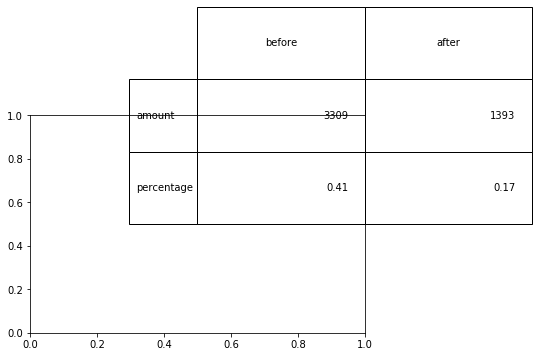

In [355]:
fig,ax=plt.subplots()
table = ax.table(cellText=np.array([np.int_(np.sum(p_mat<0.01)),
                            ['%.2f'%i for i in (np.sum(p_mat<0.01)/len(p_mat))]]),
         colLabels=['before','after'],rowLabels=['amount','percentage'],bbox=(0.5,0.5,1,1))


# 草稿

In [233]:
plot_mat = pd.DataFrame([rsquared_mat1.dataset,rsquared_mat2.dataset]).T
plot_mat.columns=['before','after']

In [153]:
p_mat = pd.DataFrame([p1.dataset,p2.dataset]).T
p_mat.columns=['before','after']
np.sum(p_mat<0.05)

before    7301
after     1824
dtype: int64

In [128]:
p_mat = pd.DataFrame([p1.label,p2.label]).T
p_mat.columns=['before','after']
np.sum(p_mat<0.01)

before    3309
after     1393
dtype: int64

In [ ]:
from scipy.stats import f

In [107]:
from scipy.stats import f
f.cdf(4.42,5,120)

0.9990079821701455

In [168]:
f.isf(0.001, 5, 120)

4.415675807297815

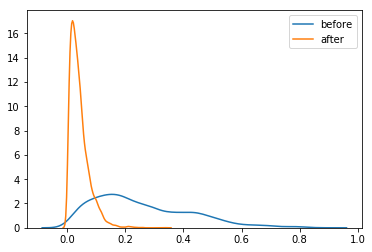

In [236]:
g = sns.kdeplot(plot_mat.before)
g = sns.kdeplot(plot_mat.after)

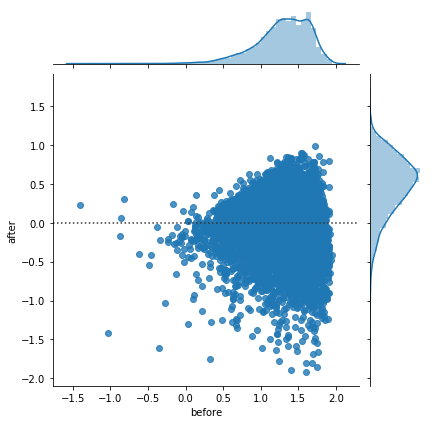

In [104]:
g = sns.JointGrid(x="before", y="after", data=np.log10(plot_mat*100))
g = g.plot_joint(sns.residplot)
g = g.plot_marginals(sns.distplot,kde=True,kde_kws={'shade':False},rug = False)

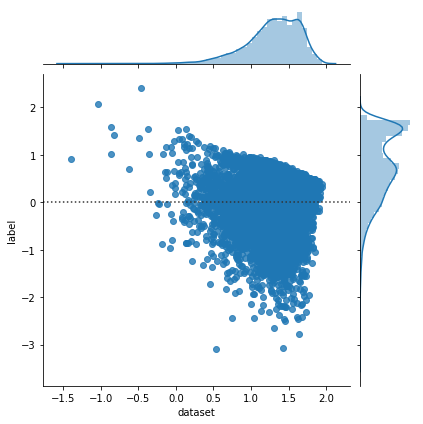

In [95]:
g = sns.JointGrid(x="dataset", y="label", data=np.log10(rsquared_mat*100))
g = g.plot_joint(sns.residplot)
g = g.plot_marginals(sns.distplot,kde=True,kde_kws={'shade':False},rug = False)